In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import pickle
from sklearn.linear_model import LinearRegression
import seaborn as sns
from utils import util
from sklearn.metrics import r2_score
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
os.environ['USE_PYGEOS'] = '0'

### Figure 5 Simulation results

In [2]:
with open('./results/simulation_results/avg_betti_curve.pkl', 'rb') as f:
    avg_betti_curve = pickle.load(f)
with open('./results/simulation_results/avg_effectiveness.pkl', 'rb') as f:
    avg_effectiveness = pickle.load(f)

In [3]:
op = [10,20,30,40,50,60] #organizer percentage
agent_num = [600, 1200, 1800, 2400, 3000, 3600, 4200] # agent number

#### Fig 7a

In [4]:
def extract_peak_times(avg_betti_curve, op, agent_num, dim=0, peak=1, threshold=60):
    df_peak = pd.DataFrame(index=op, columns=agent_num)
    
    for o in op:
        for a in agent_num:
            key = f'op_{o}_agent_{a}'
            peaks = scipy.signal.find_peaks(avg_betti_curve[key][dim])[0]
            
            if len(peaks) == 0:
                df_peak.loc[o, a] = 0
            elif peak == 1:
                first_peak = peaks[0]
                df_peak.loc[o, a] = 0 if first_peak > threshold else first_peak
            elif peak == 2:
                if len(peaks) < 2:
                    df_peak.loc[o, a] = peaks[0] if len(peaks) == 1 and peaks[0] > threshold else 0
                else:
                    second_peak = next((p for p in peaks if p > threshold), 0)
                    df_peak.loc[o, a] = second_peak
    
    df_peak.index = ['10%', '20%', '30%', '40%', '50%', '60%']
    df_peak = df_peak.astype(float)
    
    return df_peak

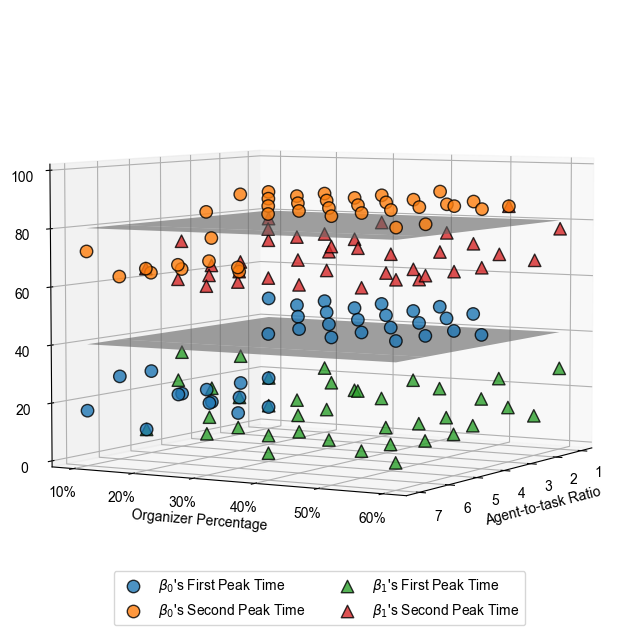

In [5]:
dim_0_peak_1 = extract_peak_times(avg_betti_curve, op, agent_num, dim=0, peak=1).values.ravel()
dim_0_peak_2 = extract_peak_times(avg_betti_curve, op, agent_num, dim=0, peak=2).values.ravel()
dim_1_peak_1 = extract_peak_times(avg_betti_curve, op, agent_num, dim=1, peak=1).values.ravel()
dim_1_peak_2 = extract_peak_times(avg_betti_curve, op, agent_num, dim=1, peak=2).values.ravel()

x_labels = [1,2,3,4,5,6,7] 
y_labels = ['10%', '20%', '30%', '40%', '50%', '60%']

x_pos = np.arange(len(x_labels))
y_pos = np.arange(len(y_labels))
x_grid, y_grid = np.meshgrid(x_pos, y_pos)

x = x_grid.ravel()
y = y_grid.ravel()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

def filter_nonzero(x, y, z):
    mask = z != 0 
    return x[mask], y[mask], z[mask]
x_f, y_f, dim_0_peak_1_f = filter_nonzero(x, y, dim_0_peak_1)
sc = ax.scatter(x_f, y_f, dim_0_peak_1_f,s=80, edgecolors='k', alpha=0.8, marker = 'o', label=r"$\beta_0$'s First Peak Time")

x_f, y_f, dim_0_peak_2_f = filter_nonzero(x, y, dim_0_peak_2)
sc = ax.scatter(x_f, y_f, dim_0_peak_2_f,s=80, edgecolors='k', alpha=0.8, marker = 'o', label=r"$\beta_0$'s Second Peak Time")

x_f, y_f, dim_1_peak_1_f = filter_nonzero(x, y, dim_1_peak_1)
sc = ax.scatter(x_f, y_f, dim_1_peak_1_f,s=80, edgecolors='k', alpha=0.8, marker = '^', label=r"$\beta_1$'s First Peak Time")

x_f, y_f, dim_1_peak_2_f = filter_nonzero(x, y, dim_1_peak_2)
sc = ax.scatter(x_f, y_f, dim_1_peak_2_f,s=80, edgecolors='k', alpha=0.8, marker = '^', label=r"$\beta_1$'s Second Peak Time")

Z_levels = [40, 80]
for z in Z_levels:
    ax.plot_surface(x_grid, y_grid, np.full_like(x_grid, z), 
                    color='gray', alpha=0.6, rstride=5, cstride=5)

ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels)
ax.set_yticks(y_pos)
ax.set_yticklabels(y_labels)

ax.set_xlabel("Agent-to-task Ratio")
ax.set_ylabel("Organizer Percentage")
ax.set_zlabel("Peak Time")
ax.set_zlim(0, 100)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.1), ncol=2, frameon=True)
ax.view_init(elev=5, azim=30) 
# plt.savefig('./3d_peak_time.pdf', bbox_inches='tight')

#### Fig 7b

In [6]:
df_eff = pd.DataFrame(index=op, columns=agent_num)
for o in op:
    for a in agent_num:
        key = f'op_{o}_agent_{a}'
        mean_value = np.mean(avg_effectiveness[key][0])
        df_eff.loc[o, a] = mean_value
df_eff.index = ['10%', '20%', '30%', '40%', '50%', '60%']

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0, 0.5, '10%'),
  Text(0, 1.5, '20%'),
  Text(0, 2.5, '30%'),
  Text(0, 3.5, '40%'),
  Text(0, 4.5, '50%'),
  Text(0, 5.5, '60%')])

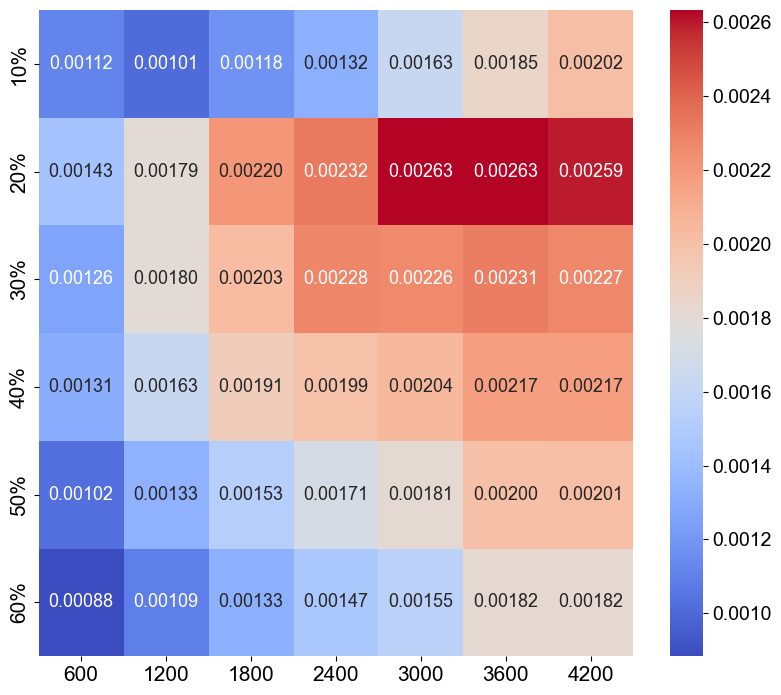

In [7]:
plt.rcParams['font.family'] = 'Arial'
df_eff = df_eff.astype(float)
plt.figure(figsize=(8, 7))
heatmap = sns.heatmap(df_eff, annot=True, fmt=".5f", cmap="coolwarm", annot_kws={'size':13},cbar=True)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
plt.tight_layout()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig('./results/figures_for_publish/heatmap_effectiveness.pdf', bbox_inches='tight')

#### Fig 7c & 7d

In [8]:
def normalize_and_stack(data_dict, index):
    stacked = np.stack(
        [util.normalized(values[index]) for values in data_dict.values()],
        axis=1
    )
    return np.nan_to_num(stacked, nan=0.0)

betti_0 = normalize_and_stack(avg_betti_curve, index=0)
betti_1 = normalize_and_stack(avg_betti_curve, index=1)
eff     = normalize_and_stack(avg_effectiveness, index=0)

/Users/anpingzhang/Documents/GitHub/zigzag_on_dynamic_social_networks/utils/util.py:104: RuntimeWarning: invalid value encountered in divide
  return (array - np.min(array)) / (np.max(array) - np.min(array))


In [9]:
# Linear regression using betti_0
model_betti_0 = LinearRegression()
model_betti_0.fit(betti_0, eff)
effectiveness_predict_betti_0 = model_betti_0.predict(betti_0)

# Linear regression using betti_1
model_betti_1 = LinearRegression()
model_betti_1.fit(betti_1, eff)
effectiveness_predict_betti_1 = model_betti_1.predict(betti_1)

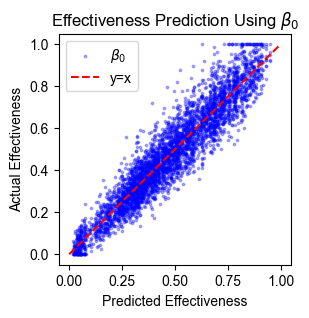

In [10]:
plt.figure(figsize=(3, 3))
plt.scatter(effectiveness_predict_betti_0.flatten(), eff.flatten(), label=r'$\beta_0$', alpha=0.3,s = 3, color='blue')
plt.plot([0, 1], [0, 1], 'r--', label='y=x')  
plt.xlabel('Predicted Effectiveness')
plt.ylabel('Actual Effectiveness')
plt.legend()
plt.title(r'Effectiveness Prediction Using $\beta_0$')
# plt.savefig('prediction_betti_0.pdf', bbox_inches='tight')
plt.show()

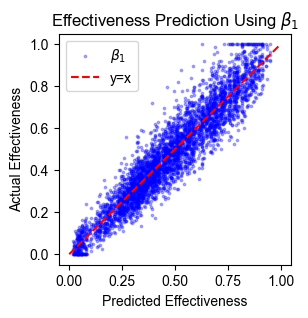

In [11]:
plt.figure(figsize=(3, 3))
plt.scatter(effectiveness_predict_betti_1.flatten(), eff.flatten(), label=r'$\beta_1$', alpha=0.3,s = 3, color='blue')
plt.plot([0, 1], [0, 1], 'r--', label='y=x')  
plt.xlabel('Predicted Effectiveness')
plt.ylabel('Actual Effectiveness')
plt.legend()
plt.title(r'Effectiveness Prediction Using $\beta_1$')
# plt.savefig('prediction_betti_1.pdf', bbox_inches='tight')
plt.show()

In [12]:
print("R^2 score (betti_1):", round(r2_score(eff, effectiveness_predict_betti_0), 4))
print("R^2 score (betti_1):", round(r2_score(eff, effectiveness_predict_betti_1), 4))

R^2 score (betti_1): 0.8856
R^2 score (betti_1): 0.8857


#### Figure 5e

100%|██████████| 2106/2106 [00:31<00:00, 67.32it/s] 


Saved figure to: /Users/anpingzhang/Documents/GitHub/zigzag_on_dynamic_social_networks/figures/betti_effectiveness_correlation_mapswipe.png


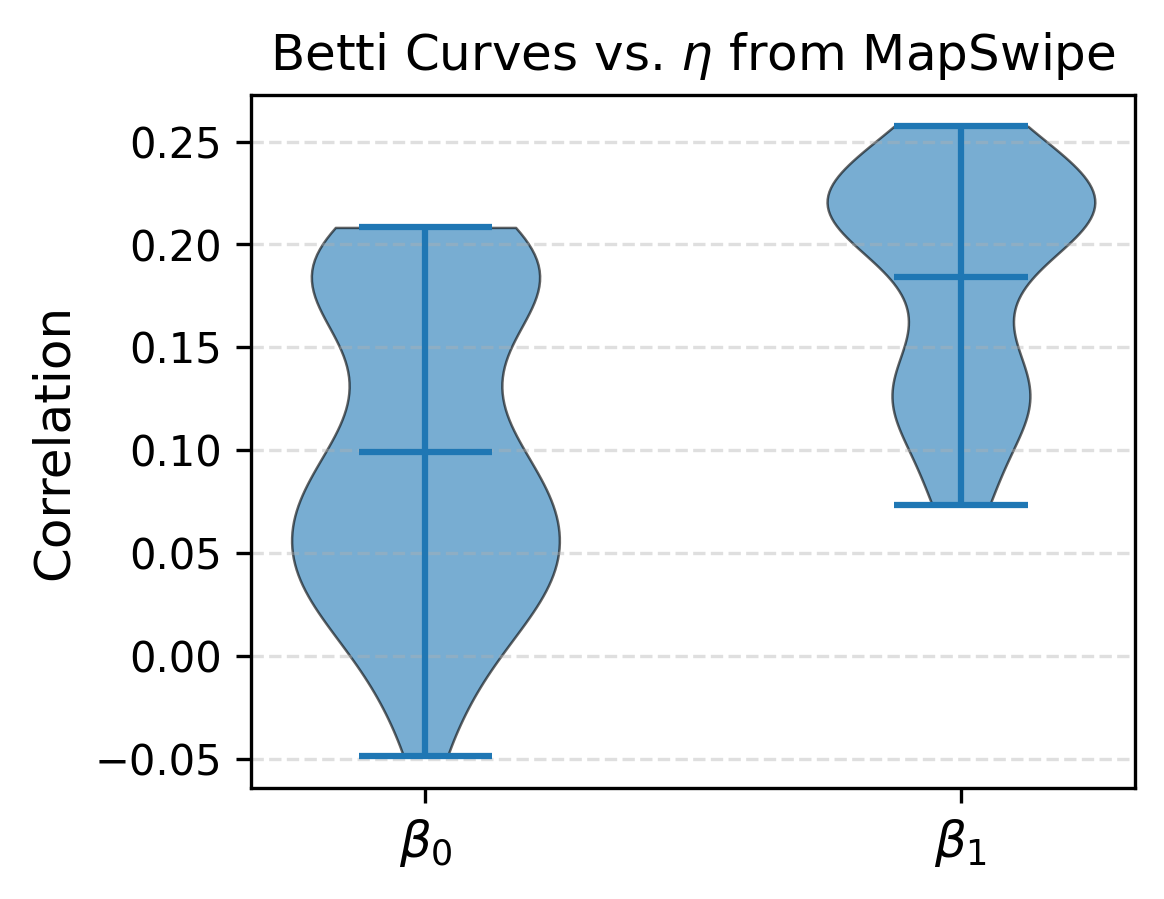

In [13]:
from pathlib import Path
import subprocess
import sys
from IPython.display import Image, display

candidate_scripts = [
    Path('utils/topo_analysis_mapswipe.py'),
    Path('../utils/topo_analysis_mapswipe.py'),
]
script = next((p for p in candidate_scripts if p.exists()), None)
if script is None:
    raise FileNotFoundError('Cannot find utils/topo_analysis_mapswipe.py from current notebook working directory.')

repo_root = script.resolve().parents[1]
output_img = repo_root / 'figures' / 'betti_effectiveness_correlation_mapswipe.png'

cmd = [sys.executable, str(script), '--output', str(output_img)]
subprocess.run(cmd, check=True, cwd=repo_root)
display(Image(filename=str(output_img)))
